# msld_py_prep Tutorial for Streamlined MS$\lambda$D Small Molecule Setup

### This tutorial assumes that you are working within a Conda environment that already has pyCHARMM installed and that you have the following tools already loaded in your session:
- ParamChem (CGenFF module)
- MMTSB 

## The problem we are trying to solve: 
Find a set of common core atoms within a molecule series that have matching atom types, connectivity, and partial atomic charges. This is a necessary requirement for the current implementation of MSLD in CHARMM, where we fragment molecules into a `common core` and the respective alchemical substituents at each perturbation site. This creates a hybrid multiple topology model.

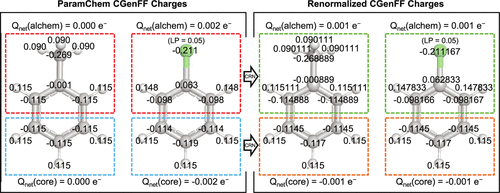

While atom type connectivity can be readily identified with a Maximum Common Substructure (MCS) search (as we do here), the partial charges of common atoms across similar molecules often differ. Thus, we perform charge renormalization to ensure common core atoms have consisten atomic charges across all molecules and that each alchemical substituent has a consistent net charge, as shown in the figure above.

### The diagram below shows the typical workflow of the msld_py_prep scripts to solve the main problem described above.

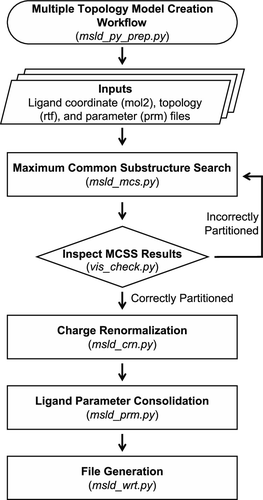

#### "Optimizing Multisite λ-Dynamics Throughput with Charge Renormalization" Jonah Z. Vilseck, Luis F. Cervantes, Ryan L. Hayes, and Charles L. Brooks Journal of Chemical Information and Modeling 2022 62 (6), 1479-1488; DOI: 10.1021/acs.jcim.2c00047

## I. Set Up Dependencies

We need to make sure we have the msld_py_prep scripts cloned, RDKit installed, PyMOL set up, and that we have a ParamChem module installed and aliased as 'cgenff' ready to use on the terminal

In [1]:
# Install RDKit, pyMOL and pandas to your conda environment if you do not have it already.
# Otherwise use the command below

# Assuming you have a conda environment loaded)
! printf 'y' | conda install -n $CONDA_DEFAULT_ENV pandas=1.3.4

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c defaults conda


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ ^C
- 

In [1]:
# Check that we have a ParamChem module in our setup
# aliased as 'cgenff', as well as pyMOL and MMTSB ready to go,
# specifically the convpdb.pl script

! type cgenff
! type pymol
! type convpdb.pl

cgenff not found
pymol is /Users/luiscv/opt/anaconda3/envs/testt/bin/pymol
convpdb.pl not found


**NOTE:** if you are running locally, chances are you might not have the cgenff module installed. If that is the case, the parameter files for the ligands generated herein are located in the `faah_ligands` directory

## II. CRN pyMOL Plugin: Setting up a hybrid topology system using charge renormalization

In a prospective MSLD small-molecule/protein binding study, one usually starts out with a crystal structure of an active lead compound bound to the protein target of interest. The goal is to make small modifications to the ligand scaffold in order to predict changes that will increase affinity or retain it while improving other properties (e.g. solubility). 

### We have a set of ligands for fatty acid amide hydrolase (FAAH), a potential therapeutic target for pain and CNS disorders. We have taken this example from our charge renormalization paper and the SMILES and respective ID's are as follows.

In [2]:
!cat faah_ligands.csv

ID,SMILES
1,c1ccccc1C([O@@])CNc2ncnc(c3ccccc3)c2
2,c1ccccc1C([O@@])CNc2ncnc(c3ccc(C)cc3)c2
3,c1ccccc1C([O@@])CNc2ncnc(c3ccc(CC)cc3)c2
4,c1ccccc1C([O@@])CNc2ncnc(c3ccc(C(C)C)cc3)c2
5,c1ccccc1C([O@@])CNc2ncnc(c3ccc(C(C)(C)C)cc3)c2
6,c1ccccc1C([O@@])CNc2ncnc(c3ccc(C(F)(F)F)cc3)c2


### 1. We will first generate these compounds' 3D structures and align them to the lead compound in the representative crystal structure. 
We can do that via our PyMOL plugin. We will initialize PyMOL by opening the representative solvated protein structure with the lead compound.

In [3]:
import os
os.system('pymol -R faah_charmmgui/step2_solvator.pdb &')

0

Feature has expired.
Feature:       PYMOL_MAIN
Expire date:   06-jul-2022
License path:  /Users/luiscv/.pymol/license.lic:/Library/Application Support/Schrodinger/licenses:
FlexNet Licensing error:-10,32


 PyMOL(TM) 2.4.2 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected OpenGL version 2.1. Shaders available.
 Detected GLSL version 1.20.
 OpenGL graphics engine:
  GL_VENDOR:   Apple
  GL_RENDERER: Apple M1
  GL_VERSION:  2.1 Metal - 71.5.9
 License Expiry date: 06-jul-2022
License expired
 Detected 8 CPU cores.  Enabled multithreaded rendering.
PyMOL>bg_color white
 CmdLoad: "" loaded as "step2_solvator".
xml-rpc server running on host localhost, port 9123


In [11]:
# Load solvated protein/ligand complex into pyMOL
import xmlrpc.client as xmlrpclib
from IPython import display
import os
import time

# Get control of the pyMOL cmd 
pwd = os.getcwd()
impath = os.path.join(pwd,'image_display.png')
hostaddress = 'http://localhost:9123'
cmd = xmlrpclib.ServerProxy(hostaddress)

# Create a separate pyMOL object
# for the crystal ligand structure
try:
    cmd.remove('lig')
except:
    pass
cmd.create('lig','resname JXV') 
cmd.disable('step2_solvator')
cmd.png(impath)


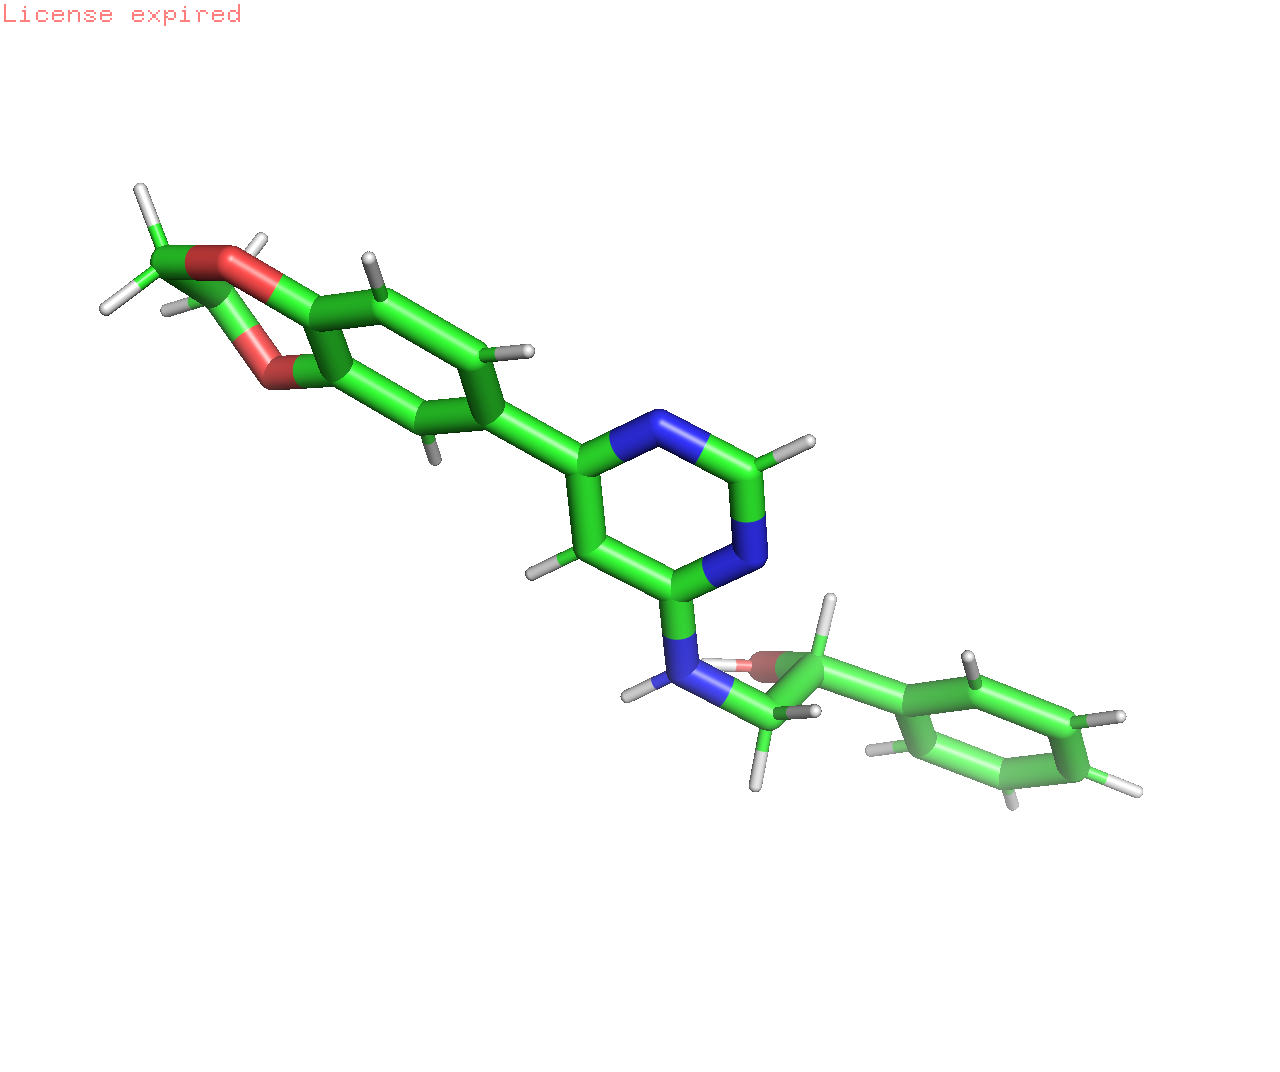

In [12]:
display.display(display.Image(impath))

In [13]:
#### Run this first to retrieve the MSLD-py-prep module
cwd = os.getcwd()
! cd ../; bash ./retrieveSubmodule.sh
os.chdir(cwd)
!ls

6mrgF.pdb              faah_charmmgui         faah_ligs
6mrgF.pka              faah_completed_example image_display.png
MSLD_Py_Prep.ipynb     faah_lig.sdf           lig.sdf
build.faah             faah_ligands.csv       xlig.str
Generating 3D coordinates...
[13:01:51] [a:1][a:2]!@;-[NX3:3][!#1:4]: 11 10 9 8, [(1 0), (1 -0.7), (1 0), (1 -0.5), (1 0), (1 -0.6)] 
[13:01:51] [!#1:1][CX4H2:2]!@;-[NX3H1:3][!#1:4]: 6 8 9 10, [(1 0), (1 0), (1 1), (1 0), (1 0), (1 0)] 
[13:01:51] [!#1:1][CX4:2]!@;-[CX4:3][!#1:4]: 5 6 8 9, [(1 0), (1 0), (1 7), (1 0), (1 0), (1 0)] 
[13:01:51] [cH1:1][c:2]!@;-[c:3]([cH1])[nX2H0:4]: 16 15 14 13, [(1 0), (-1 20), (1 0), (1 0), (1 0), (1 0)] 
[13:01:51] [a:1][c:2]!@;-[CX4H1:3][N,O:4]: 0 5 6 7, [(1 0), (1 0), (1 0), (1 0.5), (1 0), (1 0)] 
[13:01:53] [a:1][a:2]!@;-[NX3:3][!#1:4]: 11 10 9 8, [(1 0), (1 -0.7), (1 0), (1 -0.5), (1 0), (1 -0.6)] 
[13:01:53] [!#1:1][CX4H2:2]!@;-[NX3H1:3][!#1:4]: 6 8 9 10, [(1 0), (1 0), (1 1), (1 0), (1 0), (1 0)] 
[13:01:53] [!#1:1][CX

#### **A.** To install the PyMOL plugin click: `Plugin tab -> Plugin Manager -> Install New Plugin Tab -> Install from local file "Choose File" button`, then navigate to and select the `MSLD-Workshop/4msld-py-prep/msld-py-prep/CRN_Plugin/__init__.py` script. Once installed you can find the plugin in the dropdown menu of the Plugin tab. 


#### **B.** Input these specs into the plugin and click the `Align` button to generate mol2 and sdf files that are aligned to the lead compound. **Specify the msld-py-prep directory** when asked where you want to save the output of the alignment.

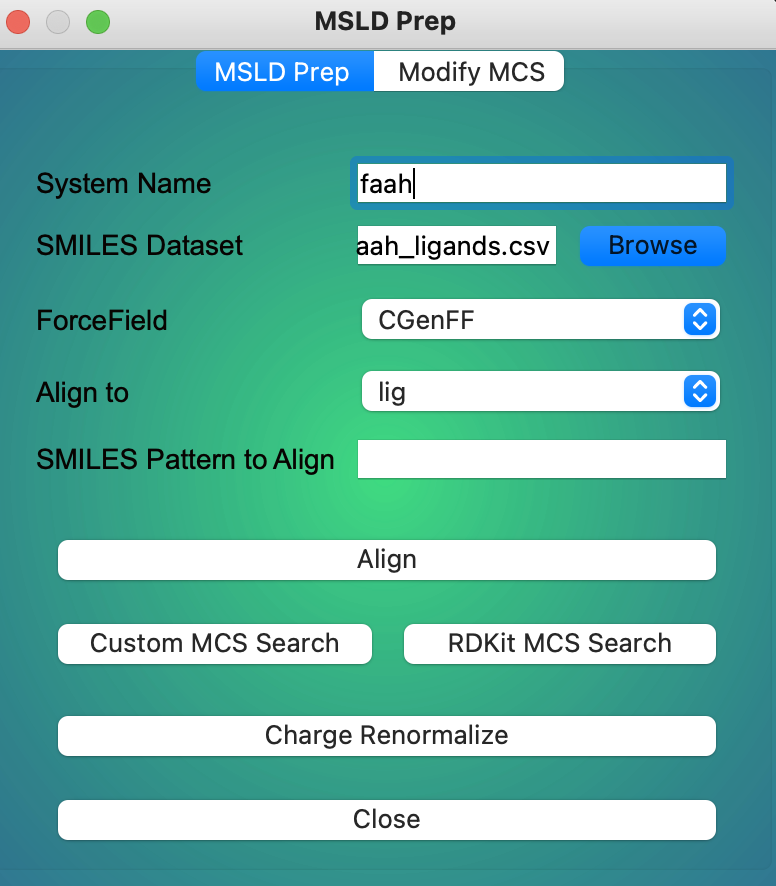

You should now have aligned molecules with their corresponding .mol2/.sdf files. Your PyMOL window should look like this:

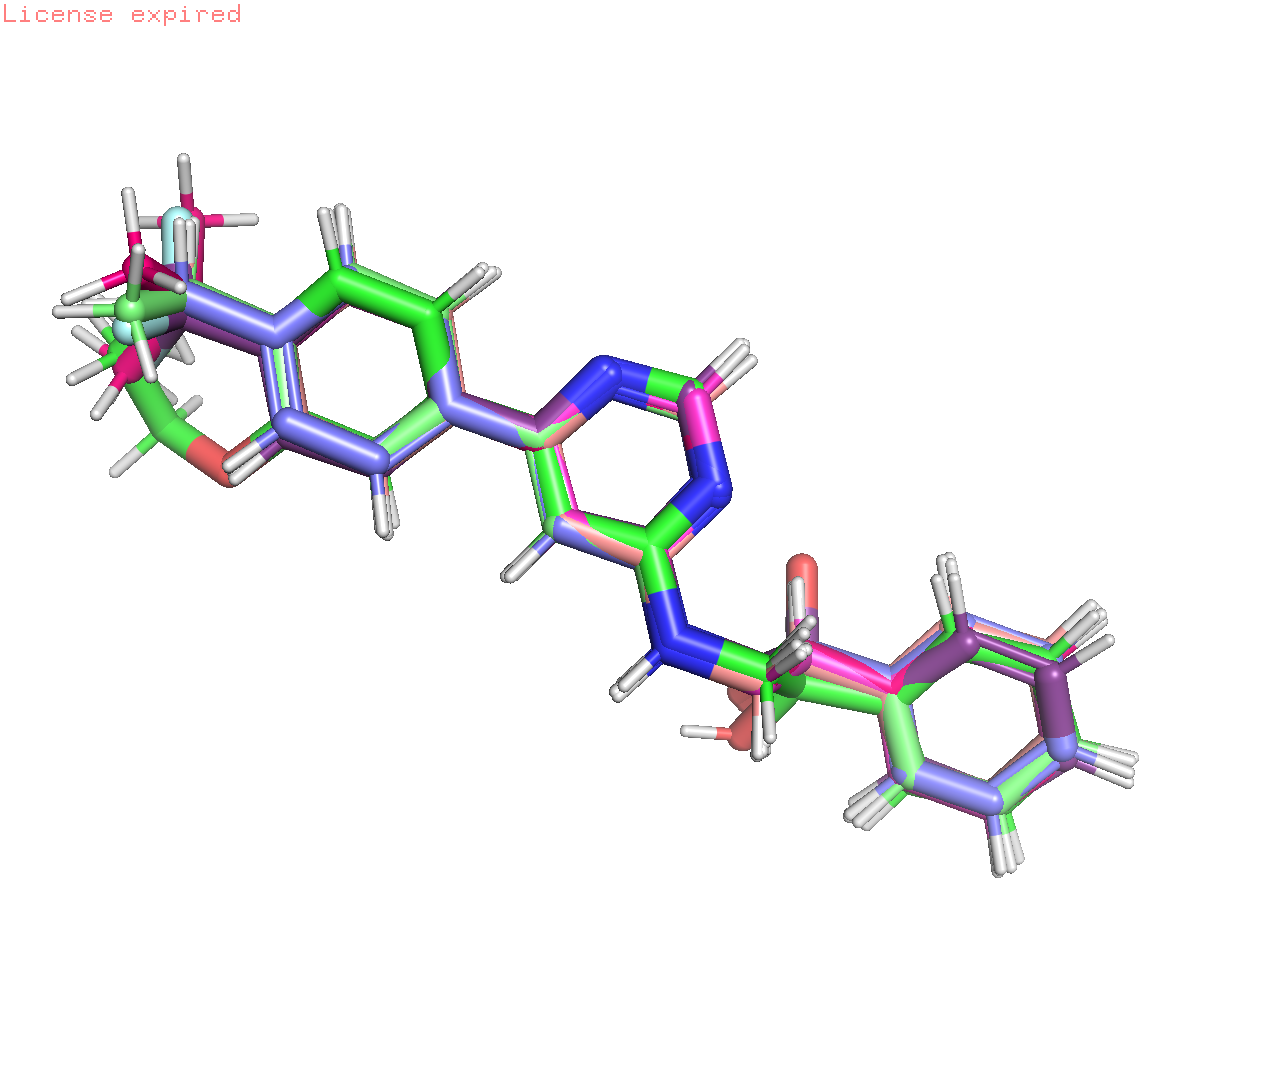

In [16]:
cmd.png(impath)
display.display(display.Image(impath))

Notice that all the molecules shown have the pyrimidine moiety in the middle. We need to visually inspect that this moiety is not flipped in some molecules. 

The orientation of the moiety will depend on your binding pocket. If the nitrogens in this moiety were flipped, we could have to manually need to tweak some torsions in pyMOL to have all of the molecules aligned before moving on. 


We also need to make sure that we have minimal clashes between the pocket and the ligands we just generated. 



In [25]:
cmd.hide('lines','solvent')
cmd.show('lines','lig around 7')
cmd.enable('step2_solvator')
cmd.png(impath)

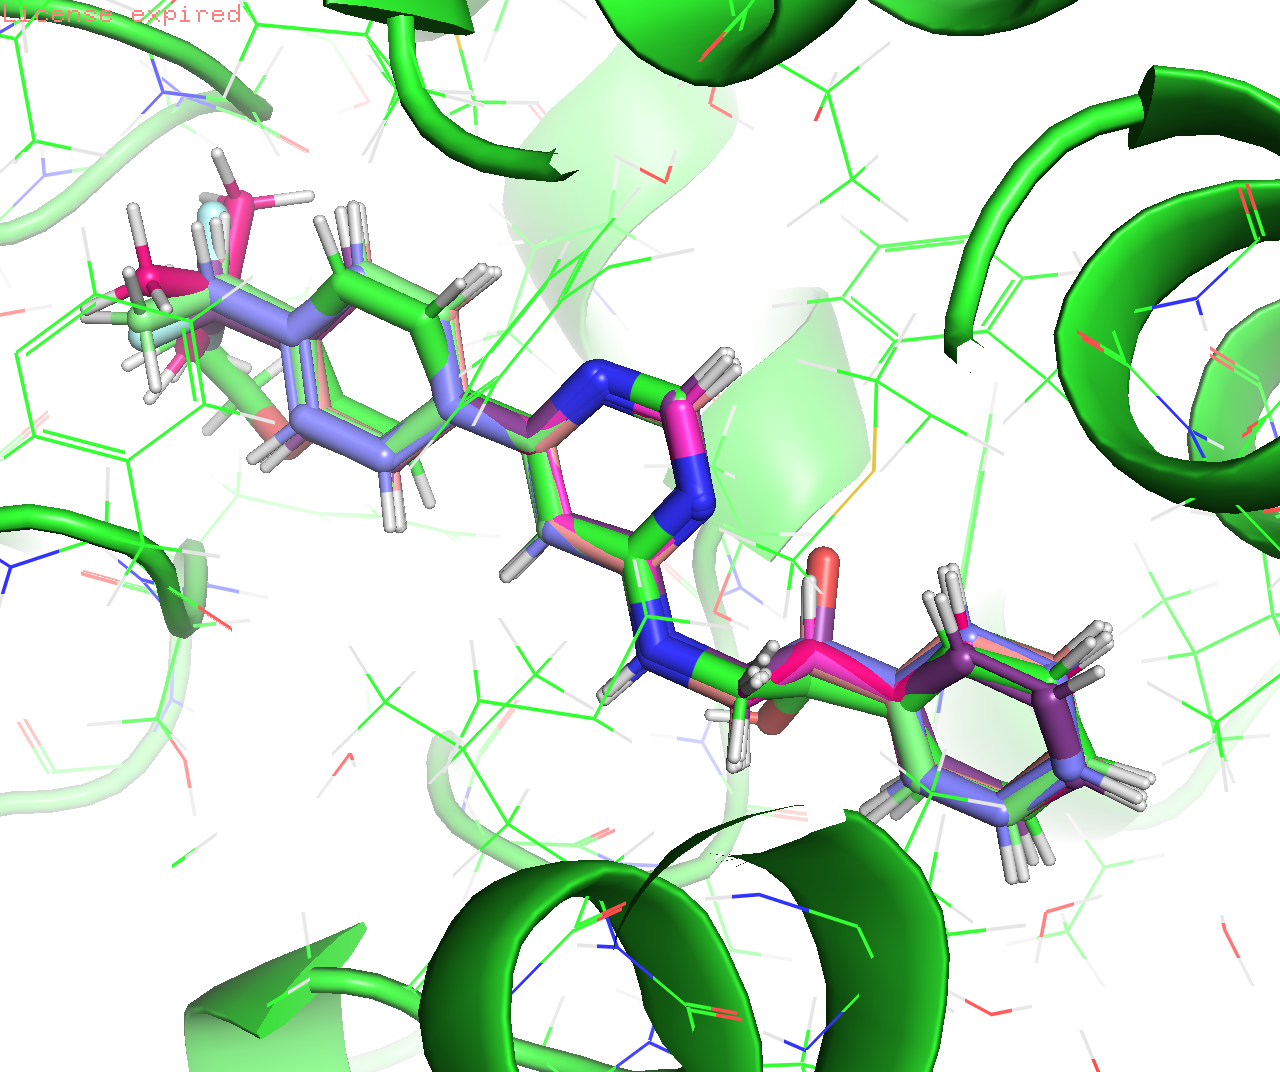

In [26]:
display.display(display.Image(impath))

Because we are only going to use the first 6 molecules of our dataset for this example, we will leave out the lead compound for this tutorial since this allows us to explain the different sections of our code a bit more clearly.
#### It should be noted, however, that you usually want your lead compound to be included in the MSLD setup, since it's usually the only experimentally proven binder in your MSLD dataset in a prospective study.

In the plugin, all that is necessary to exclude the lead ligand is to disable it on the object window as so:

In [27]:
cmd.disable('step2_solvator')
cmd.disable('lig')

Your object ribbon should look like this:

<div>
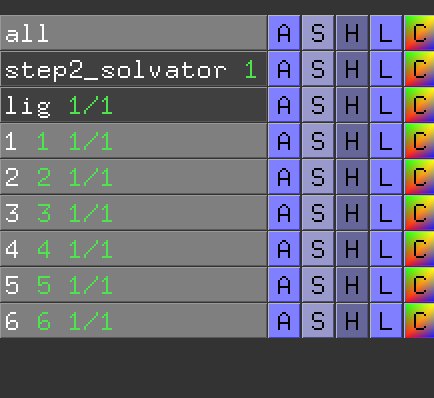
</div>

Proceed to Part III to show how we would do this on the command line.

## III. Setting up a Hybrid Topology System Using Charge Renormalization

Now that we have aligned molecules with a CHARMM compatible parameter/topology and a mol2 file, we can proceed in the plugin by clicking each button sequentially. If you have the ParamChem module loaded, then you can proceed as is. Otherwise, we will copy the parameter files before running the next set of buttons. 

In [28]:
!pwd
!cp faah_ligs/*str .
!ls

/Users/luiscv/umich/research/add_mcs/what/MSLD-Workshop/4msld-py-prep/faah_prep
1.mol                  4.mol2                 MSLD_Py_Prep.ipynb
1.mol2                 4.sdf                  build.faah
1.sdf                  4.str                  faah_charmmgui
1.str                  5.mol                  faah_completed_example
2.mol                  5.mol2                 faah_lig.sdf
2.mol2                 5.sdf                  faah_ligands.csv
2.sdf                  5.str                  faah_ligs
2.str                  6.mol                  image_display.png
3.mol                  6.mol2                 lig.sdf
3.mol2                 6.sdf                  ref.png
3.sdf                  6.str                  xlig.str
3.str                  6mrgF.pdb
4.mol                  6mrgF.pka


In [29]:
# Specify molecules you wish to do crn on
! rm mol_list.txt
! for mol in `seq 1 6`; do echo $mol >> mol_list.txt; done


# Specify system name in msld_py_prep.py
! sed 's/\"name\"/\"faah\"/g' ../msld-py-prep/msld_py_prep.py | tee ../msld-py-prep/msld_py_prep.py

rm: mol_list.txt: No such file or directory
#! /usr/bin/env python

####
#### Executable script to build MSLD ready ligand files
#### JV,LC 01/2022
####

import msld_chk
import msld_mcs
import msld_crn
import msld_prm
import msld_wrt
import glob

###
### This script is executed in 2 steps to (1st) build the MCSS
### and (2nd) perform charge renormalization. This allows the user
### to check that the identified MCSS is correct with vis_check.py.
### Thus, the user should manually call msld_py_prep.py twice.
###
### All ligand structure files (mol2) and toppar files must be 
### available prior to running this script
###
### The inFrag list of lists allows you to move core atoms into 
### alchemical fragments at specific sites. Each nested list 
### corresponds to a single site attached to the ligand core.
###
### The AnCore list of lists allows you to move (non-DUM) atoms
### listed as "anchor atoms" (atoms connecting core and fragment
### components) into the core upon charge renormali

In [30]:
# # Run MCS Step
! python ../msld-py-prep/msld_py_prep.py
! cat MCS_for_MSLD.txt

chk finished
Large RMSD for CORE atom O008 - RMSD > 0.8 (0.806).
MCS results printed to MCS_for_MSLD.txt
Reference Ligand is 1
# Maximum Common Substructure Search for Multisite Lambda Dynamics (JV 2022)
# 6 molecules processed

NSUBS 6

REFLIG 1

CORE 
1 C007 H028 O008 C009 H029 H030 N010 H031 C011 N012 C013 H032 N014 C015 C016 C022 H038 C006 C002 H024 C003 H025 C004 H026 C017 H033 C021 H037 C005 H027 C001 H023
2 C007 H029 O008 C009 H030 H031 N010 H032 C011 N012 C013 H033 N014 C015 C016 C023 H041 C006 C004 H027 C003 H026 C002 H025 C022 H040 C017 H034 C001 H024 C005 H028
3 C007 H030 O008 C009 H031 H032 N010 H033 C011 N012 C013 H034 N014 C015 C016 C024 H044 C006 C002 H026 C003 H027 C004 H028 C017 H035 C023 H043 C005 H029 C001 H025
4 C007 H031 O008 C009 H032 H033 N010 H034 C011 N012 C013 H035 N014 C015 C016 C025 H047 C006 C004 H029 C003 H028 C002 H027 C024 H046 C017 H036 C001 H026 C005 H030
5 C007 H032 O008 C009 H033 H034 N010 H035 C011 N012 C013 H036 N014 C015 C016 C026 H050 C006 C002 H

After running this either through the `run vis_check.py` command or through the plugin after pressing the `MCS Search` button, you should get the following:


In [31]:
# Visualize 
from rdkit.Chem import PyMol
v = PyMol.MolViewer()
v.server.do('run ../msld-py-prep/vis_check.py')
cmd.hide('labels','step2_solvator')

PyMOL>set valence,1
 Setting: valence set to on.
PyMOL>set stick_rad,0.15
 Setting: stick_radius set to 0.15000.
PyMOL>set mouse_selection_mode,0
 Setting: mouse_selection_mode set to 0.
PyMOL>set line_width,2
 Setting: line_width set to 2.00000.
PyMOL>set selection_width,10
 Setting: selection_width set to 10.00000.
PyMOL>set auto_zoom,0
 Setting: auto_zoom set to 0.
PyMOL>run ../msld-py-prep/vis_check.py


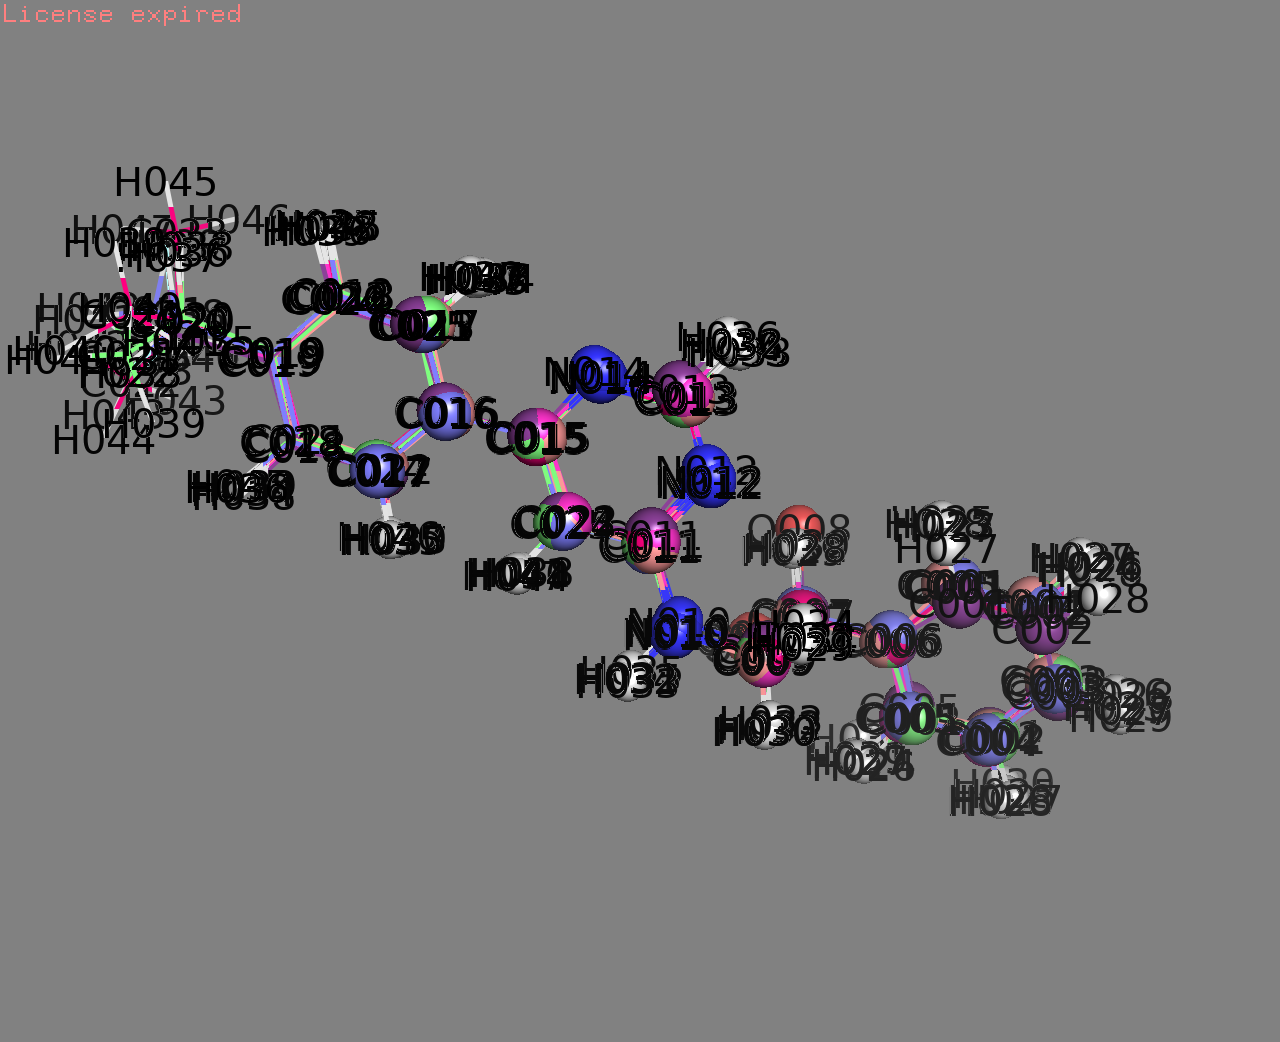

 You clicked /1///UNK`0/C021 -> (pk1)
Will be moving to site 1
H037 will also be removed since it is bound to C021
[{'1': ['C018', 'H034', 'C019', 'H035', 'C020', 'H036'], '2': ['C018', 'H035', 'C019', 'C021', 'H039', 'C020', 'H036', 'H037', 'H038'], '3': ['C018', 'H036', 'C019', 'C022', 'H042', 'C020', 'H037', 'H038', 'C021', 'H039', 'H040', 'H041'], '4': ['C018', 'H037', 'C019', 'C023', 'H045', 'C020', 'H038', 'C022', 'H042', 'H043', 'H044', 'C021', 'H039', 'H040', 'H041'], '5': ['C018', 'H038', 'C019', 'C024', 'H048', 'C020', 'C023', 'H045', 'H046', 'H047', 'C022', 'H042', 'H043', 'H044', 'C021', 'H039', 'H040', 'H041'], '6': ['C018', 'H038', 'C019', 'C024', 'H039', 'C020', 'F023', 'F022', 'F021']}]
 You clicked /1///UNK`0/C017 -> (pk1)
 You clicked /1///UNK`0/C017 -> (pk1)
Will be moving to site 1
H033 will also be removed since it is bound to C017
['C016']
[{'1': ['C018', 'H034', 'C019', 'H035', 'C020', 'H036', 'C021', 'H037'], '2': ['C018', 'H035', 'C019', 'C021', 'H039', 'C020',

In [33]:
cmd.hide('label','step2_solvator')
cmd.png(impath)
display.display(display.Image(impath))

Atoms shown as hard spheres are part of the `core` and the ones shown as stick are `substituents`, which we will be transforming alchemically throughout the MSLD simulation. In this case we only have one single site.

We sometimes might need a different MCS, which is why we want to modify the `MCS_for_MSLD.txt` file a little bit before proceeding. Some might prefer to have the whole ring be part of the substituents.  Atoms C017 and C021 in molecule 1 have been marked as part of the core. We might want to move them to the substituents.

To fix this in the plugin, go on edit mode and select this atom in this molecule (you can also select the corresponding atom in the other molecules). Once the atom is selected in edit mode, we can exclude it from the core by pressing the `Move` button and making the following specifications. We do this atom by atom (and only select the heavy atoms since hydrogens get moved with them.)

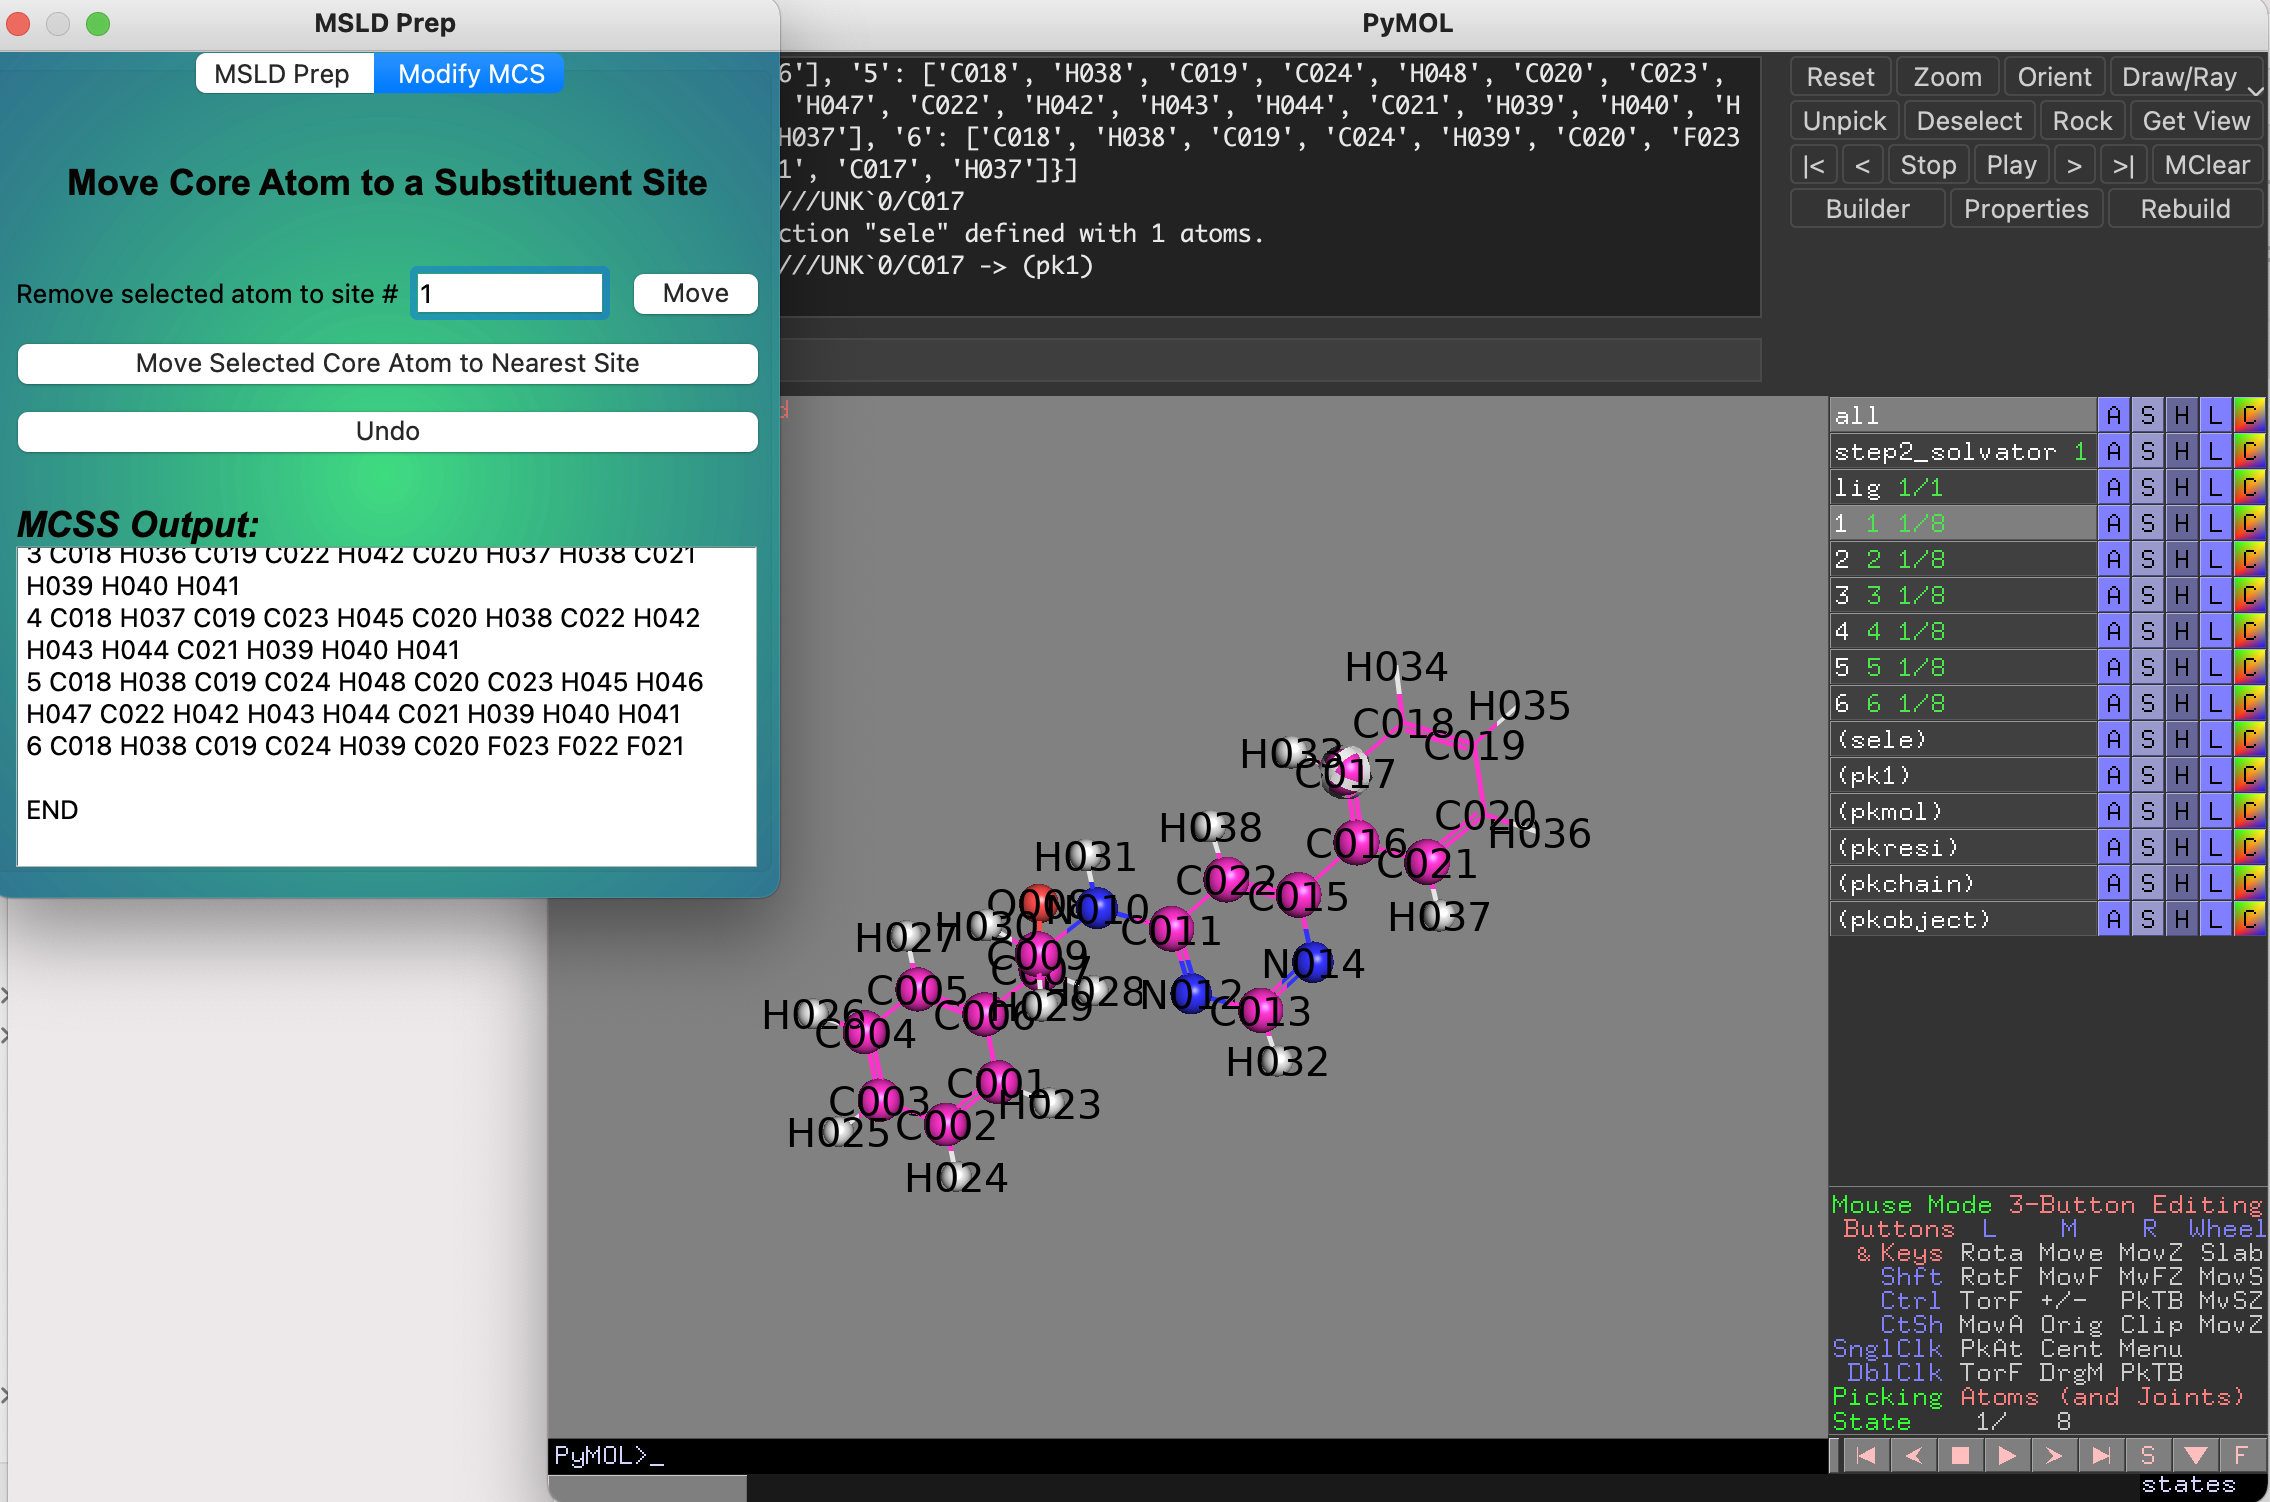

Since we only have one site of variation in this system, we have specified that we want to move it to site 1.

We are now ready to do the charge renormalization step, along with the fragmenting of the molecules in order to separate the core from the different fragments/substituents. This should output a directory called `build.jnk1`

In [34]:
# Run charge renormalization Step 
# (Same command as for MCS Step but scripts identify that we have an `MCS_for_MSLD.txt` file)
! python ../msld-py-prep/msld_py_prep.py


Fragment Charge Differences Following Charge ReNormalization:
Charge Change Chk: old sitesum [0.0, -0.0, 0.0, -0.0, -0.0, -0.0]
Charge Change Chk: Qs round to these integers [0, 0, 0, 0, 0, 0]
Charge Change Chk: new sitesum [0.0, -0.0, 0.0, -0.0, -0.0, -0.0]
 
Site 1 Q(avg) = 0.0
  1 Q(diff from avg) = 0.0 Q(orig) = 0.0 (a 0.0% diff from orig charges)
  2 Q(diff from avg) = 0.0 Q(orig) = -0.0 (a 0.0% diff from orig charges)
  3 Q(diff from avg) = 0.0 Q(orig) = 0.0 (a 0.0% diff from orig charges)
  4 Q(diff from avg) = 0.0 Q(orig) = -0.0 (a 0.0% diff from orig charges)
  5 Q(diff from avg) = 0.0 Q(orig) = -0.0 (a 0.0% diff from orig charges)
  6 Q(diff from avg) = 0.0 Q(orig) = -0.0 (a 0.0% diff from orig charges)

Core Q(sum) = -1.0
  Q(orig) = -1.0 (a -0.0% diff from orig charges)


Old to New Atom Name Translations found in: translation.txt
MSLD Files Written Into: build.faah

maxnum from site1_sub1_frag.pdb
maxnum from site1_sub2_frag.pdb
maxnum from site1_sub3_frag.pdb
maxnum from

### We need to pay close attention to the output to see if we have not changed the charges significantly.

From the charge renormalization paper cited at the beginning of this notebook, we can see that we start seeing changes in free energy predictions if we see an RMSD charge deviation from about 0.001e-
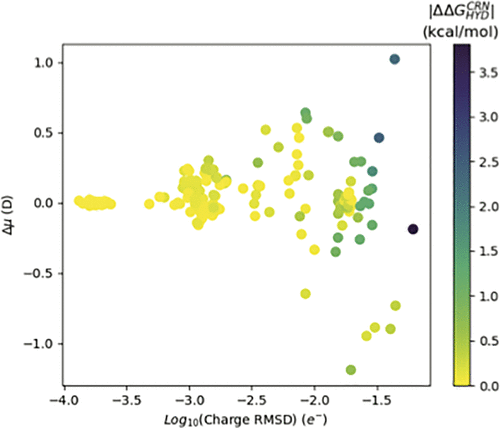

Now that we have made sure that we have not altered the charges as much, we can visualize the pdb files in the `build.faah` directory to make sure that we have a correct fragmentation.

In [46]:
cmd.reinitialize()


for sub in range(6):
    cmd.load(f"build.faah/site1_sub{sub+1}_frag.pdb")
cmd.load('build.faah/core.pdb')
cmd.load('faah_charmmgui/step2_solvator.pdb')
cmd.center('core')
cmd.bg_color('white')
cmd.zoom('core',10)

cmd.png(impath)

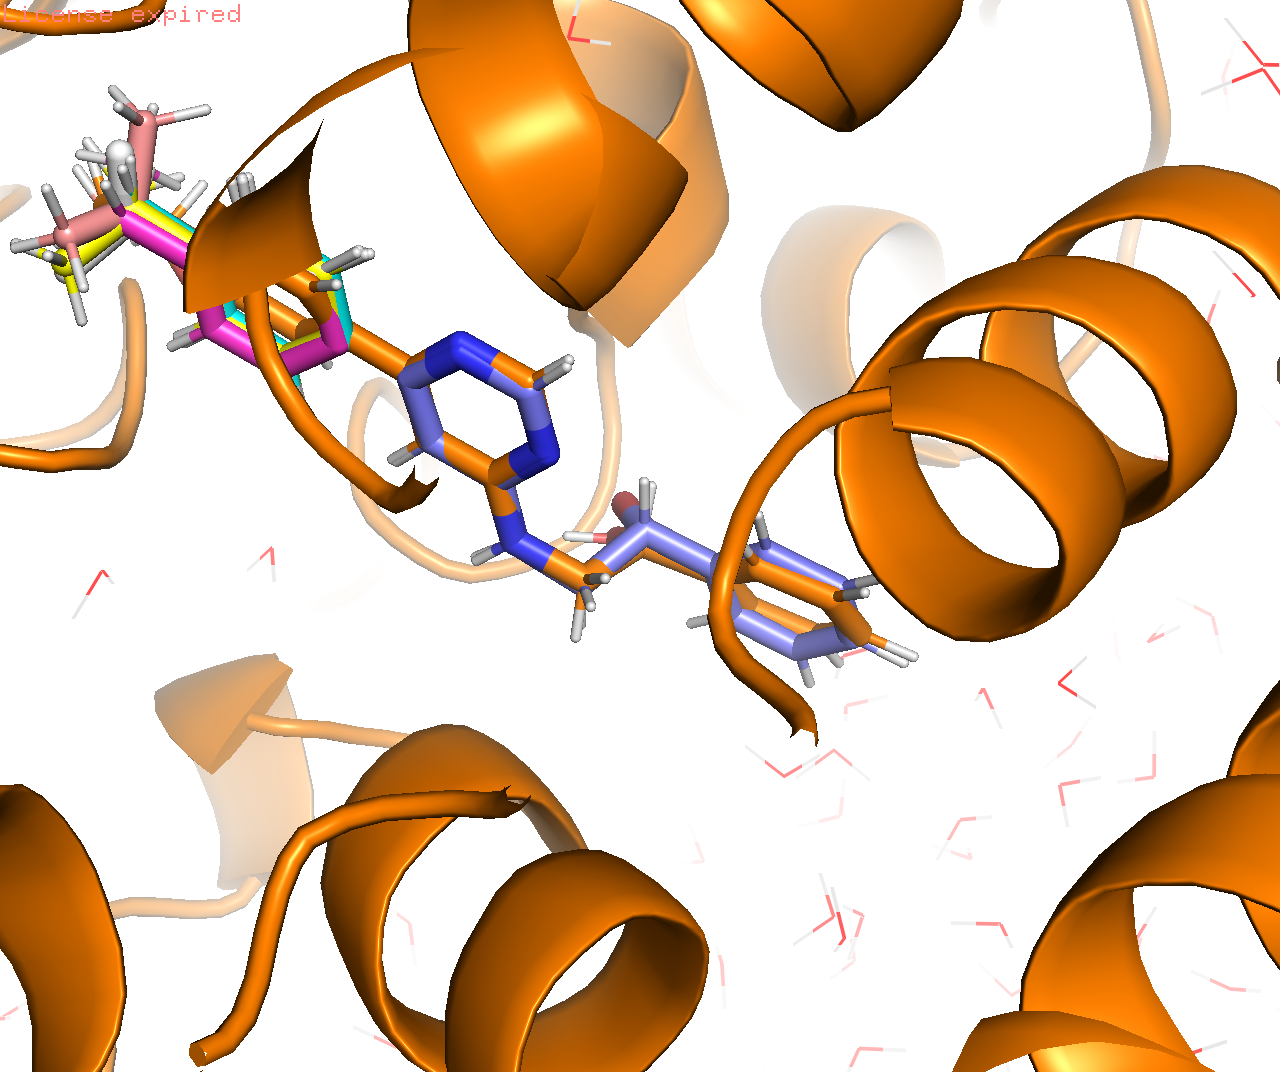

In [47]:
display.display(display.Image(impath))

### We are done! 
With the correct pdb, rtf, and prm files, as well as a CHARMM MSLD script (`jnk1.inp`) in the `build.jnk1` directory, we are ready for input into MSLD and pyCHARMM.

## pyCHARMM Import

In [ ]:
import os
import sys
import numpy as np

# These are a subset of the pycharmm modules that were installed when
# pycharmm was installed in your python environment
import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm